In [5]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [6]:
using Zygote, Lux, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib
using Random: Xoshiro
using MLUtils: DataLoader

# Load the dataset

In [7]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [8]:
using Base: @kwdef

In [9]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [10]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [11]:
data_dir = "pixel_data/"

"pixel_data/"

In [12]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [13]:
q, ylocal, pt = get_samples(data_dir, 1:2)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [14]:
q_test, ylocal_test, pt_test = get_samples(data_dir, 3);

In [15]:
q |> size

(20, 13, 21, 99991)

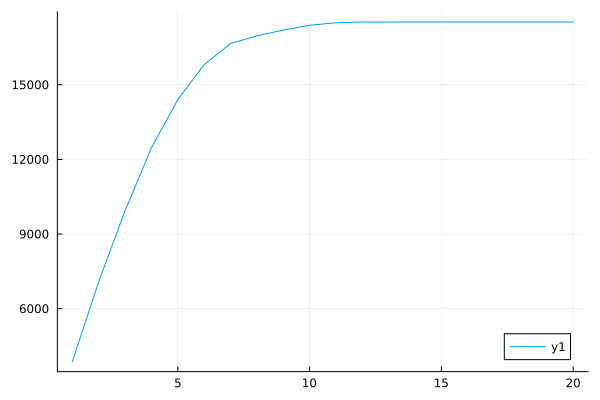

In [16]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

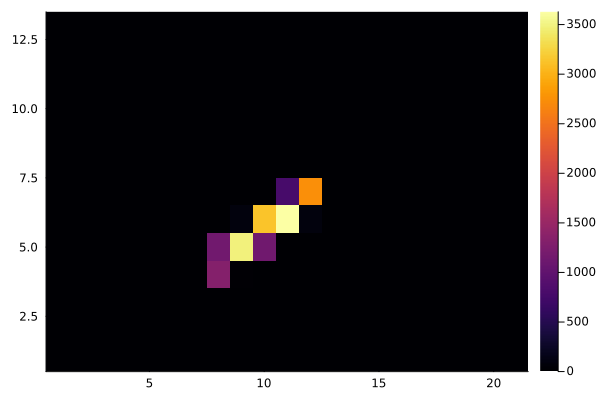

In [18]:
heatmap(q[12,:,:,128])

In [19]:
ylocal |> size

(99991,)

In [20]:
pt |> size

(99991,)

In [21]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [22]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [23]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [24]:
x |> size

(20, 13, 21, 128)

In [26]:
n_px = size(x, 2)
n_in = n_px + 1

14

# Set up the model

In [27]:
function process_inputs(x, y_local)
    x = scale_charge(x)
    x = sum(x, dims=(1,3))
    n_batch = size(x, 4)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [28]:
process_inputs(x, xl)

14×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …   0.0       0.0        0.0
  0.0       0.00728   0.0       0.0          0.0       0.0002     0.0
  0.01548   3.89436   0.04744   0.02484      0.0       0.89496    0.02688
  4.53608  22.421     5.53156  10.3167       0.0      45.6419     8.18032
 13.0276   28.691    14.8939   42.2308       0.08     88.6978    38.3292
 18.1824   29.1889   21.668    39.5168   …  17.8984   40.6906    50.7078
 17.2391   11.8402   24.0816   74.3496      49.9682   -1.49488   27.1796
 12.8535   -0.58136   8.4348   -3.04328      0.58264   0.0       -1.61592
  7.73868   0.0      -0.44068  -0.00316     -0.19872   0.0        0.0
 -0.07108   0.0       0.0       0.0         -0.0002    0.0        0.0
  0.0       0.0       0.0       0.0      …   0.0       0.0        0.0
  0.0       0.0       0.0       0.0          0.0       0.0        0.0
  0.0       0.0       0.0       0.0          0.0       0.0        0.0
 -6.94104  -4.33669  -7.79379  -2.67448      

In [29]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    Dense(n_in => 128, relu),
    Dense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction(#54),
    layer_3 = Dense(14 => 128, relu),   # 1_920 parameters
    layer_4 = Dense(128 => 3),          # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [30]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_4 = (weight = Float32[0.13702868 0.101796284 … -0.05596938 0.085558705; -0.0332754 -0.17838912 … 0.06668846 0.05473953; 0.076739706 -0.17085312 … -0.16301952 0.21299712], bias = Float32[0.0; 0.0; 0.0;;])), (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [31]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([0.01214567732900318 -0.1725669569411746 … -0.15307581412527665 -0.08851119867648208; 0.0510823641174505 0.07570501569633484 … 0.08255367913795988 0.06868923515012494; 0.027368462730503543 0.07079240815104772 … -0.02746827246153697 0.0725062289877543], (layer_1 = (running_mean = [2.7343750407453623e-5, 0.011720312674646264, 0.158769846115855, 1.0494967656387197, 3.214049110393063, 4.16443265580488, 3.6319093041196675, 1.1148337041123164, 0.11779922050534516, -0.004528312567477114, -0.00042331250630784777, 0.0, 0.0, 0.07180550185123537], running_var = [0.9000008921638939, 1.0404967775678888, 4.9352839507701995, 44.36456898678814, 214.18895577466316, 280.3147835280541, 244.4854051874365, 56.37100367649326, 5.12052608225659, 0.9041690609789671, 0.90022934380656, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [32]:
y_naive |> size

(3, 128)

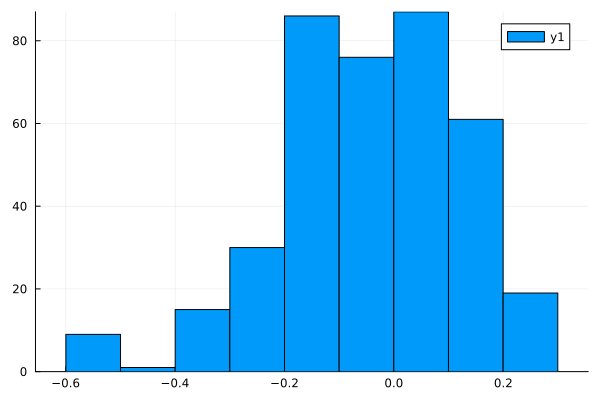

In [33]:
histogram(y_naive |> vec)

In [34]:
using Statistics: std, median, mean

In [35]:
using OneHotArrays

In [36]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [37]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [38]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [39]:
logitcrossentropy(y_pred, y) = mean(-1 * sum(y .* logsoftmax(y_pred); dims=1))

logitcrossentropy (generic function with 1 method)

In [40]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = logitcrossentropy(y_pred, y)
    return loss, st
end

loss (generic function with 1 method)

In [41]:
@time loss(x, xl, y, model, ps, st, 0.2)

  0.453130 seconds (1.58 M allocations: 113.033 MiB, 4.67% gc time, 99.80% compilation time)


(1.0671833696755837, (layer_1 = (running_mean = [2.7343750407453623e-5, 0.011720312674646264, 0.158769846115855, 1.0494967656387197, 3.214049110393063, 4.16443265580488, 3.6319093041196675, 1.1148337041123164, 0.11779922050534516, -0.004528312567477114, -0.00042331250630784777, 0.0, 0.0, 0.07180550185123537], running_var = [0.9000008921638939, 1.0404967775678888, 4.9352839507701995, 44.36456898678814, 214.18895577466316, 280.3147835280541, 244.4854051874365, 56.37100367649326, 5.12052608225659, 0.9041690609789671, 0.90022934380656, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [42]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [43]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 10)

[ Info: Constructing model and starting training


 54.969497 seconds (39.22 M allocations: 252.010 GiB, 18.11% gc time, 18.78% compilation time)


(Any[0.8612945230142794, 0.8189846713499884, 0.8034542932715117, 0.7919823279165568, 0.7831331563823071, 0.7760184813761843, 0.7701398537056913, 0.7652679416533774, 0.761195205433124, 0.7577449034917065], (layer_1 = (scale = Float32[0.99683416, 1.0615674, 1.2445, 1.2891955, 1.2025081, 1.1120936, 1.1845595, 1.2668447, 1.2292684, 0.74367744, 0.81807566, 0.92950624, 0.73287314, 0.7691191], bias = Float32[-0.18294106, -0.014277815, 0.09332356, 0.24194135, 0.24630246, 0.27212933, 0.19152819, 0.11722978, 0.03809789, -0.046172373, -0.1913211, -0.041315183, -0.18614326, 0.14272933]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.04121707 0.036657143 … 0.099719435 -0.25265676; -0.1575623 0.2683913 … 0.08579527 -0.11146523; … ; 0.13731954 -0.12101569 … -0.13275225 -0.21286121; 0.02518275 -0.34801787 … 0.1612123 -0.38707024], bias = Float32[-0.19116487; -0.051708926; … ; 0.11254895; -0.0884216;;]), layer_4 = (weight = Float32[0.105684884 0.1791852 … -0.11098842 0.110227264; -0.2186189 -0

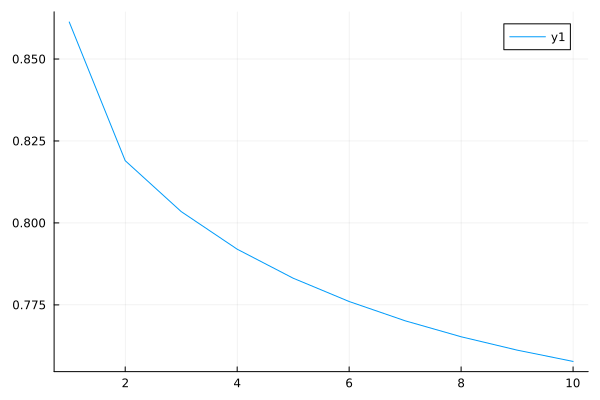

In [44]:
plot(loss_history)

In [45]:
loss_history2, pst2, stt2 = train(model, pst, stt, train_loader, 0.2, epochs = 190)

[ Info: Constructing model and starting training


(Any[0.7547768946131774, 0.7522037075680794, 0.74991476771429, 0.7478217193631368, 0.7458913212343936, 0.7440925103260801, 0.7424065445963846, 0.7408262215095079, 0.7393543584438127, 0.7379702468422258  …  0.6791390707140493, 0.6790379217001248, 0.6789366389372549, 0.6788321072409842, 0.6787287931703172, 0.6786258396214413, 0.6785255076722027, 0.6784248991110527, 0.678324381248915, 0.6782242232333829], (layer_1 = (scale = Float32[0.83571804, 1.1924583, 1.9107968, 1.6840228, 1.3019402, 1.1210879, 1.3598914, 1.7455184, 2.1025393, 0.50202805, 0.42543182, 0.2817989, 0.16965303, 0.5685185], bias = Float32[-0.11526647, 0.10526793, 0.35591862, 0.62416863, 0.64664674, 0.589401, 0.6483249, 0.4384851, 0.099256925, -0.06516334, -0.2309557, -0.01763851, -0.28585872, 0.061709255]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.032440364 -0.17733333 … 0.015560728 -0.6889827; -0.0276941 0.23204394 … 0.17108034 -0.80802625; … ; -0.14459701 -0.25731227 … -0.22504452 -0.7556784; 0.10929386 -0.4

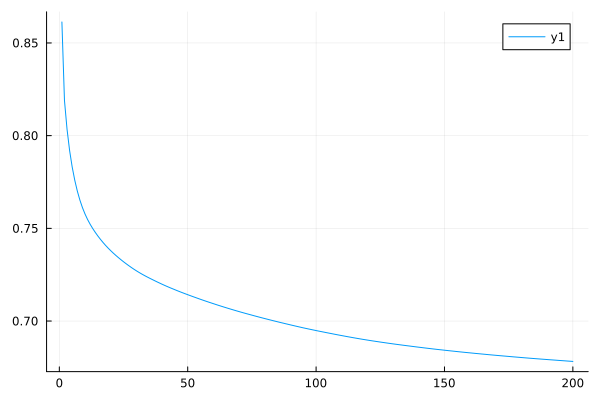

In [51]:
plot(vcat(loss_history, loss_history2))

In [52]:
pst = pst2

(layer_1 = (scale = Float32[0.83571804, 1.1924583, 1.9107968, 1.6840228, 1.3019402, 1.1210879, 1.3598914, 1.7455184, 2.1025393, 0.50202805, 0.42543182, 0.2817989, 0.16965303, 0.5685185], bias = Float32[-0.11526647, 0.10526793, 0.35591862, 0.62416863, 0.64664674, 0.589401, 0.6483249, 0.4384851, 0.099256925, -0.06516334, -0.2309557, -0.01763851, -0.28585872, 0.061709255]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.032440364 -0.17733333 … 0.015560728 -0.6889827; -0.0276941 0.23204394 … 0.17108034 -0.80802625; … ; -0.14459701 -0.25731227 … -0.22504452 -0.7556784; 0.10929386 -0.4940644 … 0.27580634 -0.81574684], bias = Float32[-0.44858623; -0.3678914; … ; 0.2526074; -0.22606228;;]), layer_4 = (weight = Float32[1.231006 2.114357 … -0.0062230593 1.7570794; -2.1551635 -0.75190055 … 0.45779416 -1.3543044; 1.5552346 -0.8111568 … -0.52822626 0.5296404], bias = Float32[0.13168217; -0.13966645; 0.099953756;;]))

In [53]:
sttf = Lux.testmode(stt2)

(layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

In [54]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.6170916032818587, (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [56]:
loss_history2[end]

0.6782242232333829

In [57]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([-1.4949550186449474 -1.4805788359801928 … -1.2135480131390688 -1.9354365470224542; 1.6823439563166045 0.5908902289920359 … 0.7130991035473113 0.8548167190368521; -1.0821257388664614 1.5058381698159486 … 1.6980443644861818 0.9416125890926411], (layer_1 = (running_mean = [0.5182423009455571, 0.6278795964072084, 3.648472243388443, 15.861443291403662, 39.669004742382114, 45.977552229162335, 34.641942681043396, 11.640081660936126, 1.4067330042548845, 0.24526209992802694, 0.18802580300197616, 0.08418600053450363, 0.0993031314082755, 0.2094285897770764], running_var = [40.899603734013134, 27.67855853087932, 132.3595513064586, 750.3003032910807, 2722.395062496112, 2487.166397521659, 2354.6690240326875, 705.3349909946818, 86.63589173414633, 17.293068252224234, 9.86353551373153, 2.283803227215314, 9.904646411140693, 19.978280087850898], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

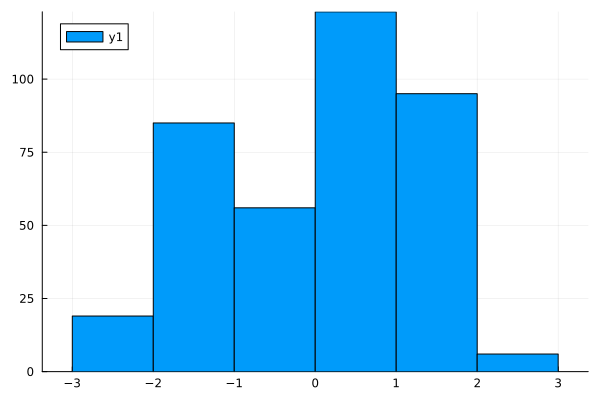

In [58]:
histogram(yt |> vec)

# Calculate the Test Loss

In [59]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [60]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    y_labels = onecold(y_pred, (0, 1, 2))
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [61]:
yth, _ = model(process_inputs(xts, xlts), pst, sttf)

([-0.8949122722399292 -1.4477439072903677 … -1.5165296223554359 -0.7746970756767336; -0.7322082836515631 -0.29448796160814206 … 1.4134440423518273 1.8812312842743162; 2.0168245666464193 1.2942456710462984 … 0.16357164786173656 -0.5437486301751924], (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [71]:
accuracy(q_test[:,:,:,1:10000], ylocal_test[1:10000], pt_test[1:10000], model, pst, sttf, 0.2)

7249

In [72]:
using LinearAlgebra: diag

In [73]:
yth, _ = model(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst, sttf)

([-0.8949122722399292 -1.4477439072903677 … -1.8892304410702097 -0.7826690107289574; -0.7322082836515631 -0.29448796160814206 … -0.22164667029876228 0.9044237137789348; 2.0168245666464193 1.2942456710462984 … 1.1659987341051752 0.7508945901184061], (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [74]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [75]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

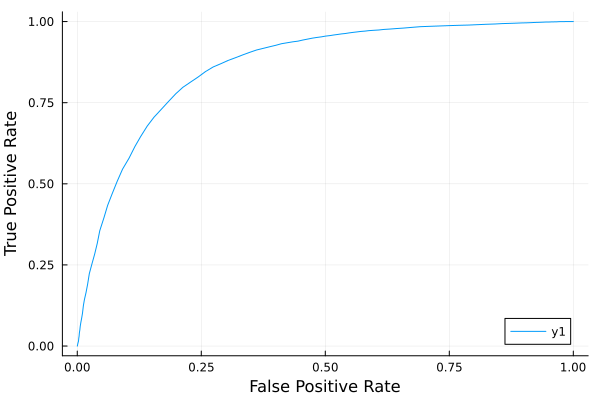

In [76]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [77]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8637174662601755, 1.2674013581169153e-8)